<a href="https://colab.research.google.com/github/bulioses/Music-Genre-Classification/blob/main/SVM_Two_Dimensional_Music_Recommender_System_(Age%26Gender).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Two Dimensional Music Recommender System SVM

In [2]:
#import google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

In [ ]:
# Function to extract features from an audio file
def extract_features(file_name):
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)

        # Extract Chroma features
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        chroma_scaled = np.mean(chroma.T, axis=0)

        # Extract Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_data)
        zcr_scaled = np.mean(zero_crossing_rate.T, axis=0)

        # Extract Spectral Roll-off
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
        rolloff_scaled = np.mean(spectral_rolloff.T, axis=0)

        # Extract Tempo
        tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sample_rate)

        # Combine all features into a single array
        features = np.hstack([mfccs_scaled, chroma_scaled, zcr_scaled, rolloff_scaled, tempo])
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        return None
    return features

In [ ]:
#Path to GTZAN dataset
dataset_path = '/content/gdrive/MyDrive/Data/genres_original'

In [ ]:
#Extract features and labels
features = []
labels = []
genres = os.listdir(dataset_path)
for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)
        feature_set = extract_features(file_path)
        if feature_set is not None:
            features.append(feature_set)
            labels.append(genre)

<ipython-input-3-ac685560dc47>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error encountered while parsing file: /content/gdrive/MyDrive/Data/genres_original/jazz/jazz.00054.wav


In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels

In [ ]:
#load demograpgic data
demographic_data = pd.read_csv('/content/gdrive/MyDrive/Data/preferred_genre_data.csv')

# Combing demographic data with audio features
combined_df = pd.concat([features_df, demographic_data], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Encode genre labels
le_genre = LabelEncoder()
combined_df['label'] = le_genre.fit_transform(combined_df['label'])

In [ ]:
#Encode gender
le_gender = LabelEncoder()
combined_df['gender'] = le_gender.fit_transform(combined_df['gender'])

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer to replace missing values with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer to the 'preferred_genre' column and transform it
combined_df['preferred_genre'] = imputer.fit_transform(combined_df[['preferred_genre']])[:, 0]

#Encode preferred genre
combined_df['preferred_genre'] = le_genre.transform(combined_df['preferred_genre'])

In [ ]:
#Combine features and demographic data
X = combined_df.drop(columns=['label'])
y = combined_df['label'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer to replace missing values with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')

# Convert column names to strings before fitting the imputer
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Fit the imputer to ALL columns and transform the entire DataFrame
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns) # Use transform on test data

In [ ]:
# Train the SVM classifier
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
#Make predictions on the test set
y_pred = svm_clf.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_genre.classes_))

Accuracy: 0.7373737373737373
Classification Report:
              precision    recall  f1-score   support

       blues       0.52      0.84      0.64        19
   classical       0.90      1.00      0.95        19
     country       0.91      1.00      0.95        21
       disco       0.59      0.54      0.57        24
      hiphop       1.00      0.81      0.89        21
        jazz       0.75      0.55      0.63        22
       metal       0.83      0.71      0.77        14
         pop       0.89      0.80      0.84        20
      reggae       0.73      0.65      0.69        17
        rock       0.48      0.52      0.50        21

    accuracy                           0.74       198
   macro avg       0.76      0.74      0.74       198
weighted avg       0.76      0.74      0.74       198



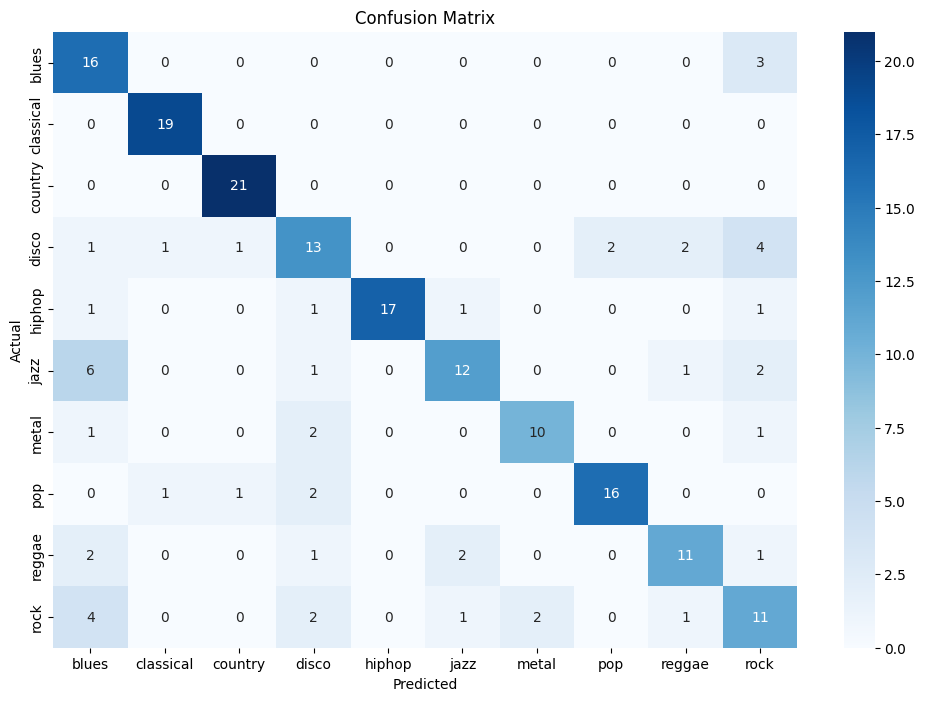

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_genre.classes_, yticklabels=le_genre.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Recommendation function
def recommend_music(age, gender):
    # Convert gender to encoded value
    gender_encoded = le_gender.transform([gender])[0]
    # Create a sample input array with dummy audio features (mean values from the training set)
    sample_features = np.mean(X_train, axis=0)[:-3]
    # Combine sample features with the provided age, gender, and a dummy preferred genre
    sample_input = np.append(sample_features, [age, gender_encoded, 0])  # 0 is a dummy value for preferred_genre
    sample_input = sample_input.reshape(1, -1)

    # Predict genre
    predicted_genre_index = svm_clf.predict(sample_input)[0]
    predicted_genre = le_genre.inverse_transform([predicted_genre_index])[0]
    return predicted_genre

In [ ]:
#Example usage
age = 40
gender = 'female'
predicted_genre = recommend_music(age, gender)
print(f"Predicted genre for a {age} year old {gender}: {predicted_genre}")

Predicted genre for a 40 year old female: country


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
#saving the model
import joblib

# Save the trained model
joblib.dump(svm_clf, 'decision_tree_model.joblib')

# Save the genre encoder
joblib.dump(le_genre, 'le_genre.joblib')

# Save the gender encoder
joblib.dump(le_gender, 'le_gender.joblib')

['le_gender.joblib']